<a href="https://www.kaggle.com/code/bimamuhammad/birdspecies-epoch109-acc87pct?scriptVersionId=139665488" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Examins the data

In [5]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# Data transform to convert data to a tensor and apply normalization

# augment train and validation dataset with RandomHorizontalFlip and RandomRotation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4234, 0.4089, 0.3468], std=[0.2358, 0.2295, 0.2207])
    ])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4234, 0.4089, 0.3468], std=[0.2358, 0.2295, 0.2207])
    ])

In [7]:
data_dir = '/kaggle/input/100-bird-species/'

In [8]:
# choose the training and test datasets
train_data = datasets.ImageFolder(f'{data_dir}train', transform=train_transform)
validation_data = datasets.ImageFolder(f'{data_dir}valid', transform=test_transform)
test_data = datasets.ImageFolder(f'{data_dir}test', transform=test_transform)

## Determine Image Mean

In [6]:
mean = 0.0
std = 0.0
total_samples = 0

for images, _ in trainloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_samples += batch_samples

mean /= total_samples
std /= total_samples

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.4234, 0.4089, 0.3468])
Standard Deviation: tensor([0.2358, 0.2295, 0.2207])


In [9]:
birds=list(train_data.class_to_idx.keys())

In [10]:
output_len= len(birds)

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
images, labels = next(iter(trainloader))

fig, axes=plt.subplots(figsize=(50, 50), ncols=2)
for idx in np.arange(2):
    ax=axes[idx]
    image = images[idx].numpy().transpose((1,2,0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image = std * image + mean
#     image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title(birds[labels[idx].item()])

In [ ]:
image.shape

## Design Model

## VGG Concept

In [8]:
# Copy VGG structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3, 64, 3, 1,1 ) # OP 224
        self.conv2=nn.Conv2d(64, 64, 3, 1,1 ) # OP 224
        self.conv3=nn.Conv2d(64, 128, 3, 1,1 ) # OP 112
        self.conv4=nn.Conv2d(128, 128, 3, 1,1 ) # OP 112
        self.conv5=nn.Conv2d(128, 256, 3, 1,1 ) # OP 56
        self.conv6=nn.Conv2d(256, 256, 3, 1,1 ) # OP 56
#         self.conv7=nn.Conv2d(256, 512, 3, 1,1 ) # OP 28
#         self.conv8=nn.Conv2d(512, 512, 3, 1,1 ) # OP 28
        
        self.pool = nn.MaxPool2d(2,2)
        self.fc1=nn.Linear(256*28*28, 525)
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.conv3(x)
        x = self.pool(self.conv4(x))
        x = self.conv5(x)
        x = self.pool(self.conv6(x))
#         x = F.relu(self.conv7(x))
#         x = self.pool(F.relu(self.conv8(x)))
        
        # flatten the tensor
        x = x.view(x.size(0), -1)
        
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        return F.log_softmax(x, dim=1)
        
model = Net()
model

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=200704, out_features=525, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3, 64, 3, 1,1 ) # OP 224
        self.conv2=nn.Conv2d(64, 128, 3, 1,1 ) # OP 224
        self.conv3=nn.Conv2d(128, 256, 3, 1,1 ) # OP 224
        self.conv4=nn.Conv2d(256, 512, 3, 1,1 ) # OP 224
        self.conv5=nn.Conv2d(512, 1024, 3, 1,1 ) # OP 224
        self.conv6=nn.Conv2d(1024, 2048, 3, 1,1 ) # OP 224
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_len)
        
        self.bc1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc2 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc3 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc4 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc5 = nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bc6 = nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        
        self.dropout=nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bc1(self.conv1(x))))
        x = self.pool(F.relu(self.bc2(self.conv2(x))))
        x = self.pool(F.relu(self.bc3(self.conv3(x))))
        x = self.pool(F.relu(self.bc4(self.conv4(x))))
        x = self.pool(F.relu(self.bc5(self.conv5(x))))
#         x = self.pool(F.relu(self.bc6(self.conv6(x))))
        
        # flatten the tensor
        x=self.avg(x)
        x = x.view(x.size(0), -1)
        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=F.log_softmax(self.fc3(x), dim=1)
        
        return x
model = Net()
model

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=525, bias=True)
  (bc1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

## Load saved dict

In [14]:
save_model='/kaggle/input/best-model-pct/bird_model_best.pt'
state_dict = torch.load(save_model)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
# train_on_gpu = torch.cuda.is_available()
# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     model.cuda()
#     print('CUDA is available!  Training on GPU ...')
    
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

model.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=525, bias=True)
  (bc1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bc3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer=optim.Adam(model.parameters(), lr=0.001)

## Don't Run unless you are sure

In [ ]:
epochs=120
valid_loss_min = np.Inf #used to track change

for epoch in range(1, epochs+1):
    
    ################
    ## train model
    ###############
    train_loss=0.0
    valid_loss=0.0
    accuracy=0.0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logps=model.forward(images)
        loss=criterion(logps, labels)
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
              
    # validation
    model.eval()
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            logps=model.forward(images)
            loss=criterion(logps, labels)
            ps=torch.exp(logps)
            top_k, top_class = ps.topk(1, dim=1)
            equality= top_class==labels.view(*top_class.shape)
            accuracy+=torch.mean(equality.type(torch.FloatTensor)).item()

            valid_loss+=loss.item()

    train_loss=train_loss/len(trainloader)
    valid_loss=valid_loss/len(validloader)
    accuracy=accuracy/len(validloader)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, accuracy))

    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'bird_model_pers.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5.661705 	Validation Loss: 5.120389 	 Accuracy: 0.037651
Validation loss decreased (inf --> 5.120389).  Saving model ...
Epoch: 2 	Training Loss: 5.168728 	Validation Loss: 4.588397 	 Accuracy: 0.079819
Validation loss decreased (5.120389 --> 4.588397).  Saving model ...
Epoch: 3 	Training Loss: 4.893553 	Validation Loss: 4.225442 	 Accuracy: 0.102786
Validation loss decreased (4.588397 --> 4.225442).  Saving model ...
Epoch: 4 	Training Loss: 4.652309 	Validation Loss: 4.112549 	 Accuracy: 0.149473
Validation loss decreased (4.225442 --> 4.112549).  Saving model ...
Epoch: 5 	Training Loss: 4.444766 	Validation Loss: 3.638631 	 Accuracy: 0.216114
Validation loss decreased (4.112549 --> 3.638631).  Saving model ...
Epoch: 6 	Training Loss: 4.240356 	Validation Loss: 3.356988 	 Accuracy: 0.243976
Validation loss decreased (3.638631 --> 3.356988).  Saving model ...
Epoch: 7 	Training Loss: 4.057192 	Validation Loss: 3.035359 	 Accuracy: 0.301581
Validation loss d

Epoch: 48 	Training Loss: 1.799014 	Validation Loss: 0.706767 	 Accuracy: 0.818148
Validation loss decreased (0.773483 --> 0.706767).  Saving model ...

Epoch: 93 	Training Loss: 1.444349 	Validation Loss: 0.501592 	 Accuracy: 0.865211
Validation loss decreased (0.554414 --> 0.501592).  Saving model ...

## Using on test data

In [16]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # 

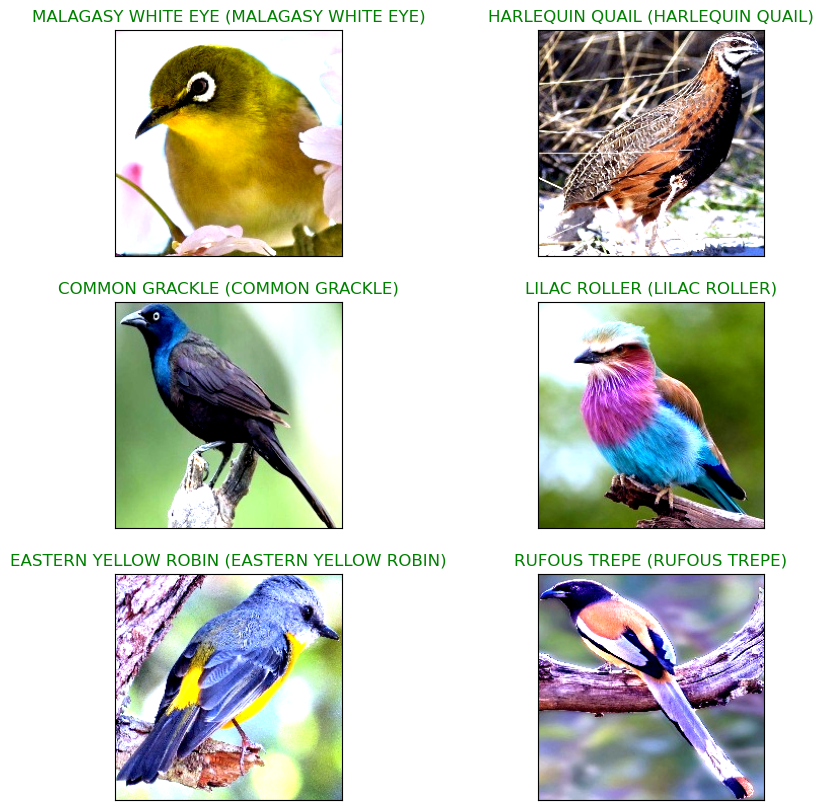

In [18]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)
images.numpy()


# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(6):
    ax = fig.add_subplot(3, int(4/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(birds[preds[idx]], birds[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))